In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem3 import ContrastiveExplanationMethod

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN(device="cpu")

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='mnist-cnn', device="cpu", load_path="models/saved_models/mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [5]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="mnist-cae", device="cpu", load_path="models/saved_models/mnist-cae-no-rs.h5")

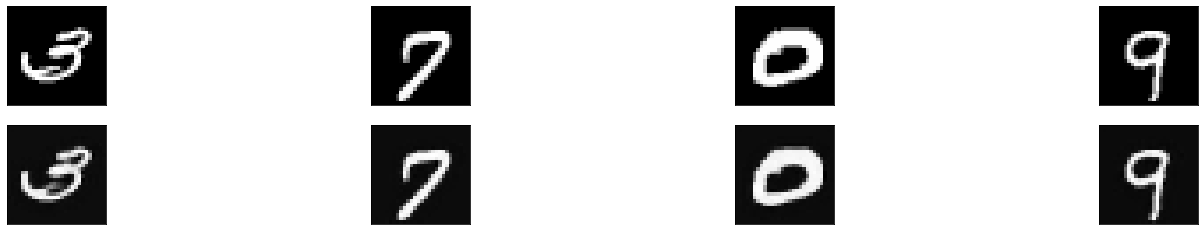

In [6]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images + .5)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [7]:
kappa = 10
gamma = 0.1
beta = 0.5
lr = 0.1
CEM = ContrastiveExplanationMethod(cnn, cae, iterations=1000, n_searches=2, kappa=kappa, gamma=gamma, beta=beta, learning_rate=lr)

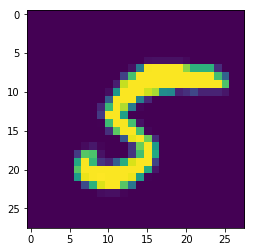

classified as: 5


In [8]:
# obtain one sample
image = dataset.get_sample_by_class(class_label=3, show_image=False)
image, _ = dataset.get_sample(show_image=False)

plt.imshow(image.squeeze())
plt.show()
print("classified as: {}".format(np.argmax(cnn(image.view(-1,1,28,28)).detach())))

In [9]:
# find pertinent negatives
mode = "PN"
CEM.fista(image, mode=mode)

new best: 18.200748443603516
new best: 16.72410011291504
search: 0 iteration: 20 c: 10 loss: 19.00 found optimum: True
new best: 16.548419952392578
search: 0 iteration: 40 c: 10 loss: 346.95 found optimum: True
new best: 16.320419311523438
search: 0 iteration: 60 c: 10 loss: 432.03 found optimum: True
search: 0 iteration: 80 c: 10 loss: 19.78 found optimum: True
search: 0 iteration: 100 c: 10 loss: 20.08 found optimum: True
search: 0 iteration: 120 c: 10 loss: 357.42 found optimum: True
new best: 16.253503799438477
search: 0 iteration: 140 c: 10 loss: 412.64 found optimum: True
search: 0 iteration: 160 c: 10 loss: 19.51 found optimum: True
search: 0 iteration: 180 c: 10 loss: 15.99 found optimum: True
search: 0 iteration: 200 c: 10 loss: 357.30 found optimum: True
search: 0 iteration: 220 c: 10 loss: 401.24 found optimum: True
search: 0 iteration: 240 c: 10 loss: 429.46 found optimum: True
search: 0 iteration: 260 c: 10 loss: 18.79 found optimum: True
search: 0 iteration: 280 c: 10 los

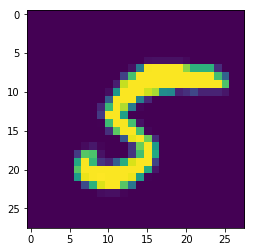

In [10]:
plt.imshow(image.squeeze())

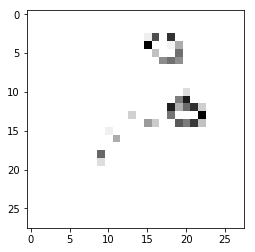

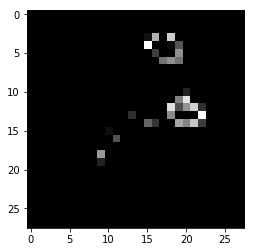

In [11]:
# perturbation
plt.imshow(image.squeeze()- CEM.best_delta.view(28,28), cmap="gray")
plt.show()
plt.imshow(CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.show()

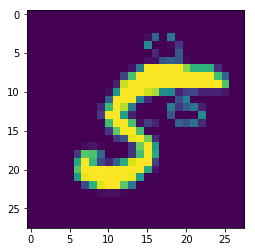

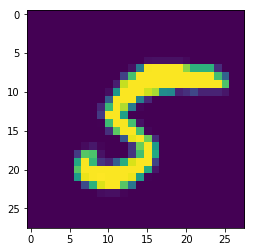

In [12]:
# original image with perturbation
plt.imshow(CEM.best_delta.view(28,28))
plt.show()

plt.imshow(image.view(28,28))
plt.show()

In [13]:
# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
before

5

In [14]:
# classification after
after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
after

5

In [15]:
# classification of delta
class_delta = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
class_delta

7

In [16]:
dirname = "saved_perturbations/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
os.makedirs(dirname, exist_ok=True)
fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
plt.imsave(fname_orig, image.squeeze(), cmap="gray")
plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")

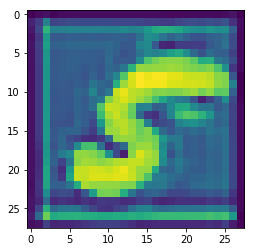

In [17]:
plt.imshow(cae(CEM.best_delta.view(1,1,28,28)+0.5).view(28,28).detach())

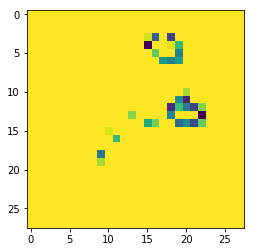

In [18]:
plt.imshow(image.squeeze() - CEM.best_delta.view(28,28).detach())

In [20]:
# for d in CEM.saved_deltas:
#     plt.imshow(d.view(28,28), cmap="gray")
#     plt.show()
#     plt.imshow(d.view(28,28) - image.squeeze(), cmap="gray")
#     plt.show()